In [167]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.utils import shuffle
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [168]:
df.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [169]:
df.location = np.array([["".join([y.strip() for y in str(x).split()])]for x in df.location]).reshape(1,-1)[0]

In [170]:
df.keyword = df.keyword.astype("str")

In [171]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer() 
stopwords = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


In [172]:
from wordcloud import WordCloud, STOPWORDS
#Wordcloud REAL
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate("".join([x.lower() for x in df.text[df.target==1]]))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

ModuleNotFoundError: No module named 'wordcloud'

In [173]:
#WORDCLOUD FAKE
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate("".join([x.lower() for x in df.text[df.target==0]]))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

NameError: name 'WordCloud' is not defined

In [174]:
def parse(sentence):
    return " ".join([lemmatizer.lemmatize(x.lower()) for x in word_tokenize(sentence) if x.lower() not in stopwords])

def pos_lemmatize(sentence):
    values = [x.lower() for x in word_tokenize(sentence)]
    pos = nltk.pos_tag(values)
    dict_pos = {"J": wordnet.ADJ,
                "NN": wordnet.NOUN,
                "VBD": wordnet.VERB,
                "VBZ": wordnet.VERB,
                "VBG": wordnet.VERB,
                "VBN": wordnet.VERB,
                "RB": wordnet.ADV}
    values = [lemmatizer.lemmatize(values[x],pos=dict_pos.get(pos[x][1], wordnet.NOUN)) for x in range(len(values))] 
    values = [value for value in values if value not in stopwords] # and len(value) > 1
    return " ".join(values)
df["n-text"] = df.text.apply(pos_lemmatize) #get lemmatized words for each word in sentence - lemmatized: walked --> walk


In [175]:
df["n-text"]

0            deed reason # earthquake may allah forgive u
1                 forest fire near la ronge sask . canada
2       resident ask 'shelter place ' notify officer ....
3       13,000 people receive # wildfire evacuation or...
4       get send photo ruby # alaska smoke # wildfire ...
                              ...                        
7608    two giant crane hold bridge collapse nearby ho...
7609    @ aria_ahrary @ thetawniest control wild fire ...
7610    m1.94 [ 01:04 utc ] ? 5km volcano hawaii . htt...
7611    police investigate e-bike collided car little ...
7612    latest : home raze northern california wildfir...
Name: n-text, Length: 7613, dtype: object

In [176]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size = 1000
df["encoded"] = [one_hot(sentence, vocab_size) for sentence in df["n-text"]]

In [177]:
df.encoded

0                     [249, 950, 875, 818, 553, 475, 569]
1                      [884, 565, 572, 670, 463, 70, 476]
2       [874, 184, 206, 554, 346, 324, 982, 993, 838, ...
3                [832, 618, 486, 647, 923, 993, 776, 653]
4            [649, 193, 547, 690, 858, 47, 923, 945, 521]
                              ...                        
7608    [86, 144, 254, 702, 236, 980, 422, 545, 934, 7...
7609    [798, 440, 220, 530, 952, 565, 653, 208, 630, ...
7610    [867, 911, 796, 269, 142, 507, 980, 30, 934, 7...
7611    [746, 557, 479, 231, 840, 107, 582, 157, 479, ...
7612    [83, 545, 298, 630, 653, 923, 562, 203, 934, 7...
Name: encoded, Length: 7613, dtype: object

In [178]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 20
Xtext = pad_sequences(list(df.encoded), maxlen=max_length, padding='pre')

In [179]:
embedding_size = min(X.shape[1]/2, 50)
embedding_size = int(embedding_size)

In [180]:
key = pd.DataFrame({"loc":df.location.unique()}).reset_index()
df = df.merge(key, left_on="location", right_on="loc")
key = pd.DataFrame({"key":df.keyword.unique()}).reset_index()
df = df.merge(key, left_on="keyword", right_on="key")
Xother = np.array(df[["index_x","index_y"]])
y = np.array(df.target)

In [156]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) #default shuffle = True but random state = 42 means always same random shuffle



In [157]:
#df["Other"] = df["location"]+df["keyword"]
#df["n-encoded"] = [one_hot(sentence, vocab_size) for sentence in df["Other"]]
#max_length = 2
#Xother = pad_sequences(list(df["n-encoded"]), maxlen=max_length, padding='pre')

In [59]:
from tensorflow.keras.layers import Embedding,Dense,LSTM,Dropout,concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(1000,embedding_vector_features,input_length=20)) ## embedding layer used 40 features to make feature representation of the sentences
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3)) ## drop out layer to make the model more regularized
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary()) ## model architechture done


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 40)            40000     
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               56400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 101       
Total params: 96,501
Trainable params: 96,501
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
history = model.fit(Xtext, y, validation_split=.2, epochs=5, batch_size=5, verbose=1)

Epoch 1/5
1218/1218 [==============================] - 9s 6ms/step - loss: 0.6176 - accuracy: 0.6581 - val_loss: 0.5468 - val_accuracy: 0.7170
Epoch 2/5
1218/1218 [==============================] - 8s 6ms/step - loss: 0.4691 - accuracy: 0.7825 - val_loss: 0.5554 - val_accuracy: 0.7203
Epoch 3/5
1218/1218 [==============================] - 8s 6ms/step - loss: 0.4169 - accuracy: 0.8178 - val_loss: 0.5617 - val_accuracy: 0.7183
Epoch 4/5
1218/1218 [==============================] - 9s 7ms/step - loss: 0.4052 - accuracy: 0.8224 - val_loss: 0.5818 - val_accuracy: 0.7124
Epoch 5/5
1218/1218 [==============================] - 8s 6ms/step - loss: 0.3728 - accuracy: 0.8399 - val_loss: 0.6125 - val_accuracy: 0.7137


In [65]:
#KERAS WITH JUST KEYWORD AND LOCATION
from tensorflow.keras.layers import Embedding,Dense,LSTM,Dropout,concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(Xother, y, test_size=0.20, random_state=42) #default shuffle = True but random state = 42 means always same random shuffle


## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(3254,embedding_vector_features,input_length=2)) ## embedding layer used 40 features to make feature representation of the sentences
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3)) ## drop out layer to make the model more regularized
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=.2, epochs=1, batch_size=5, verbose=1)


1218/1218 [==============================] - 4s 3ms/step - loss: 0.6408 - accuracy: 0.6249 - val_loss: 0.6967 - val_accuracy: 0.5181


In [111]:
y.shape

(7613,)

In [181]:
arr = np.concatenate((Xtext, Xother), axis=1)
arr

array([[   0,    0,    0, ...,  569,    0,    0],
       [   0,    0,    0, ...,  476,    0,    0],
       [   0,    0,    0, ...,  575,    0,    0],
       ...,
       [   0,    0,    0, ...,  165, 3250,  221],
       [   0,    0,    0, ...,  686, 3251,  221],
       [   0,    0,    0, ...,  368, 3252,  221]])

In [186]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.20, random_state=42) #default shuffle = True but random state = 42 means always same random shuffle

Xtext_train = x_train[:,:-2]
Xother_train = x_train[:,-2:]
Xtext_test = x_test[:,:-2]
Xother_test = x_test[:,-2:]

In [200]:
def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Embedding(1000,embedding_vector_features,input_length=20)) ## embedding layer used 40 features to make feature representation of the sentences
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3)) ## drop out layer to make the model more regularized
    
    return model

def create_cnn(dim, regress=False):
    model = Sequential()
    model.add(Embedding(4000,embedding_vector_features,input_length=2)) ## embedding layer used 40 features to make feature representation of the sentences
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dropout(0.3)) ## drop out layer to make the model more regularized
    
    # return our model
    return model

In [201]:
mlp = create_mlp(Xtext.shape[1], regress=False)
cnn = create_cnn(Xother.shape[1], regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(1, activation="sigmoid")(combinedInput)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [202]:
history = model.fit([Xtext_train, Xother_train], y_train, validation_split=.2, epochs=1, batch_size=5, verbose=1)

975/975 [==============================] - 30s 24ms/step - loss: 0.6806 - accuracy: 0.5605 - val_loss: 0.6278 - val_accuracy: 0.5878


In [127]:
loss, accuracy = model.evaluate([Xtext_test,Xother_test],y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 81.024295


In [132]:
tf = pd.read_csv("test.csv")

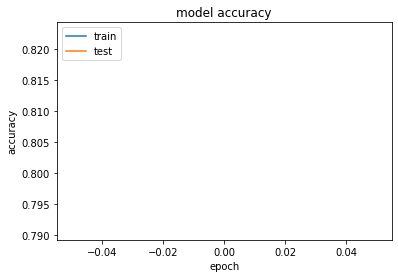

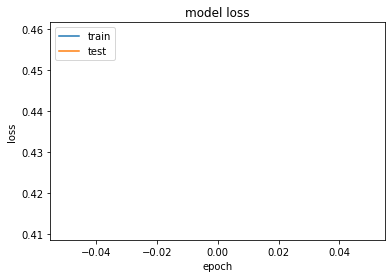

In [128]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#predictions = model.predict(x_test).reshape(1,-1).round(0)
#len(y_test[predictions[0] == y_test])/len(y_test)

In [298]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


In [ ]:
# Building Pipeline for raw text transformation: INTERESTING
clf = Pipeline([
    ('vect', TfidfVectorizer(stop_words= "english")),
    ('classifier', LogisticRegression()),
    ])